# Part 1 – Data I/O with Pandas
Goal: Learn how to read and write data in the formats you'll use as a quant developer:
- CSV (`pd.read_csv`, `df.to_csv(index=False)`)
- Excel (`pd.read_excel`, `df.to_excel`)
- HTML tables (`pd.read_html`)
- SQL (with SQLite demo)
Tip: use `%pwd` in Jupyter to see your working directory.

In [1]:
import sys, subprocess

# Ensure openpyxl for Excel support
try:
    import openpyxl
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "openpyxl"])
    import openpyxl

import pandas as pd
from sqlalchemy import create_engine
from io import StringIO
from IPython.display import display

# ---------------- CSV Example ----------------
csv_df = pd.DataFrame({"A":[1,2,3], "B":[10,20,30]})
csv_df.to_csv("demo.csv", index=False)
df = pd.read_csv("demo.csv")
print("CSV -> DataFrame:")
display(df.head())

# ---------------- Excel Example ----------------
df.to_excel("demo.xlsx", sheet_name="Sheet1", index=False)
df_xlsx = pd.read_excel("demo.xlsx", sheet_name="Sheet1", engine="openpyxl")
print("\nExcel -> DataFrame:")
display(df_xlsx.head())

# ---------------- HTML Table Example ----------------
html = """
<table>
<tr><th>name</th><th>value</th></tr>
<tr><td>alpha</td><td>1</td></tr>
<tr><td>beta</td><td>2</td></tr>
</table>
"""
tables = pd.read_html(StringIO(html))  # ✅ wrap in StringIO to avoid FutureWarning
print("\nHTML Table -> DataFrame:")
display(tables[0])

# ---------------- SQL Example (SQLAlchemy) ----------------
engine = create_engine("sqlite:///:memory:")
df.to_sql("my_table", engine, index=False)
df_sql = pd.read_sql("SELECT * FROM my_table", engine)
print("\nSQL (SQLite via SQLAlchemy) -> DataFrame:")
display(df_sql)


CSV -> DataFrame:


,A,B
0,1,10
1,2,20
2,3,30



Excel -> DataFrame:


,A,B
0,1,10
1,2,20
2,3,30



HTML Table -> DataFrame:


,name,value
0,alpha,1
1,beta,2



SQL (SQLite via SQLAlchemy) -> DataFrame:


,A,B
0,1,10
1,2,20
2,3,30


### Exercise Solutions
- **E1:** Save `df` as `result.csv` without index, reload and check there is no `Unnamed: 0` column.
- **E2:** Create a second Excel sheet with another small table and read it back.
- **E3:** Create a new SQL table with 2 text columns and query it with `LIKE`.


In [2]:
from sqlalchemy import text  # para queries seguras

# --- E1: Guardar y volver a cargar CSV ---
df.to_csv("result.csv", index=False)
df_loaded = pd.read_csv("result.csv")
print("CSV loaded:")
print(df_loaded)

# --- E2: Añadir hoja a Excel y leerla ---
other_df = pd.DataFrame({"C":[100,200], "D":[300,400]})
with pd.ExcelWriter("demo.xlsx", mode="a", engine="openpyxl") as writer:
    other_df.to_excel(writer, sheet_name="Sheet2", index=False)

df_xlsx_2 = pd.read_excel("demo.xlsx", sheet_name="Sheet2", engine="openpyxl")
print("\nExcel (Sheet2) loaded:")
print(df_xlsx_2)

# --- E3: Crear tabla y hacer SELECT con SQLAlchemy 2.x ---
with engine.connect() as conn:
    conn.execute(text("CREATE TABLE names (first TEXT, last TEXT)"))
    conn.execute(text("INSERT INTO names VALUES ('Ada','Lovelace')"))
    conn.execute(text("INSERT INTO names VALUES ('Alan','Turing')"))
    result = conn.execute(text("SELECT * FROM names WHERE first LIKE 'A%'"))
    df_sql_names = pd.DataFrame(result.fetchall(), columns=result.keys())

print("\nSQL Query Result:")
print(df_sql_names)


CSV loaded:
   A   B
0  1  10
1  2  20
2  3  30

Excel (Sheet2) loaded:
     C    D
0  100  300
1  200  400

SQL Query Result:
  first      last
0   Ada  Lovelace
1  Alan    Turing


# Part 2 – DataFrame Essentials (with Solutions)

Learn:
- Column selection
- Row selection
- Creating/dropping columns
- Setting/resetting index
- Applying custom functions


In [3]:
from sqlalchemy import text  # para queries seguras

# --- E1: Guardar y volver a cargar CSV ---
df.to_csv("result.csv", index=False)
df_loaded = pd.read_csv("result.csv")
print("CSV loaded:")
print(df_loaded)

# --- E2: Añadir hoja a Excel y leerla ---
other_df = pd.DataFrame({"C":[100,200], "D":[300,400]})
with pd.ExcelWriter("demo.xlsx", mode="a", engine="openpyxl") as writer:
    other_df.to_excel(writer, sheet_name="Sheet2", index=False)

df_xlsx_2 = pd.read_excel("demo.xlsx", sheet_name="Sheet2", engine="openpyxl")
print("\nExcel (Sheet2) loaded:")
print(df_xlsx_2)

# --- E3: Crear tabla y hacer SELECT con SQLAlchemy 2.x ---
with engine.connect() as conn:
    conn.execute(text("CREATE TABLE names (first TEXT, last TEXT)"))
    conn.execute(text("INSERT INTO names VALUES ('Ada','Lovelace')"))
    conn.execute(text("INSERT INTO names VALUES ('Alan','Turing')"))
    result = conn.execute(text("SELECT * FROM names WHERE first LIKE 'A%'"))
    df_sql_names = pd.DataFrame(result.fetchall(), columns=result.keys())

print("\nSQL Query Result:")
print(df_sql_names)


CSV loaded:
   A   B
0  1  10
1  2  20
2  3  30


ValueError: Sheet 'Sheet2' already exists and if_sheet_exists is set to 'error'.

### Exercise Solutions
- **E4:** Create `Z_norm` = (Z - mean)/std
- **E5:** Sub-DataFrame with rows `['A','C','E']` and columns `['W','Z']`
- **E6:** Label column `W` as `'positive'` or `'negative'`


In [ ]:
# E4
df2['Z_norm'] = (df2['Z'] - df2['Z'].mean()) / df2['Z'].std()
display(df2[['Z','Z_norm']])

# E5
sub_df = df2.loc[['A','C','E'], ['W','Z']]
display(sub_df)

# E6
df2['W_label'] = df2['W'].apply(lambda x: 'positive' if x>0 else 'negative')
display(df2[['W','W_label']])


# Part 3 – Handling Missing Data (with Solutions)


In [5]:
import pandas as pd
import numpy as np  # <-- IMPORTANTE para usar np.nan

d = {
    'A': [1, 2, np.nan],
    'B': [5, np.nan, np.nan],
    'C': [1, 2, 3]
}
md = pd.DataFrame(d)
print("Original DataFrame:\n", md)

# Drop rows with any NaN
print("\nDrop rows with any NaN:\n", md.dropna())

# Drop columns with any NaN
print("\nDrop columns with any NaN:\n", md.dropna(axis=1))

# Keep rows with at least 2 non-NaN values
print("\nKeep rows with >=2 non-NaN values:\n", md.dropna(thresh=2))

# Fill missing values (A gets mean of A, B gets 0)
print("\nFill missing values:\n", md.fillna({'A': md['A'].mean(), 'B': 0}))


Original DataFrame:
      A    B  C
0  1.0  5.0  1
1  2.0  NaN  2
2  NaN  NaN  3

Drop rows with any NaN:
      A    B  C
0  1.0  5.0  1

Drop columns with any NaN:
    C
0  1
1  2
2  3

Keep rows with >=2 non-NaN values:
      A    B  C
0  1.0  5.0  1
1  2.0  NaN  2

Fill missing values:
      A    B  C
0  1.0  5.0  1
1  2.0  0.0  2
2  1.5  0.0  3


# Part 4 – GroupBy, Merge, Join, Concatenate (with Solutions)


In [6]:
sales = pd.DataFrame({
    'company':['GOOG','MSFT','FB','GOOG','MSFT','FB'],
    'person':['A','B','C','D','E','F'],
    'sales':[200,120,340,210,90,180]
})
print(sales.groupby('company')['sales'].agg(['count','mean','sum']))

# concat
d1 = pd.DataFrame({'A':[1,2], 'B':[3,4]}, index=[0,1])
d2 = pd.DataFrame({'A':[5,6], 'B':[7,8]}, index=[2,3])
print(pd.concat([d1,d2]))

# merge
left = pd.DataFrame({'key':['K0','K1','K2'], 'A':[1,2,3]})
right= pd.DataFrame({'key':['K0','K1','K3'],'B':[10,20,30]})
print(pd.merge(left, right, on='key', how='inner'))
print(pd.merge(left, right, on='key', how='outer'))

# join
lj = left.set_index('key')
rj = right.set_index('key')
print(lj.join(rj, how='outer'))


         count   mean  sum
company                   
FB           2  260.0  520
GOOG         2  205.0  410
MSFT         2  105.0  210
   A  B
0  1  3
1  2  4
2  5  7
3  6  8
  key  A   B
0  K0  1  10
1  K1  2  20
  key    A     B
0  K0  1.0  10.0
1  K1  2.0  20.0
2  K2  3.0   NaN
3  K3  NaN  30.0
       A     B
key           
K0   1.0  10.0
K1   2.0  20.0
K2   3.0   NaN
K3   NaN  30.0


# Part 5 – Matplotlib Basics (with Solutions)


In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
x = np.linspace(0,5,50)
y = x**2

fig, ax = plt.subplots(figsize=(7,3))
ax.plot(x, y, color='#FF8800', lw=2, ls='--',
        marker='o', markersize=5, markerfacecolor='yellow',
        markeredgecolor='black', alpha=0.9, label='x^2')
ax.set_title('Basic Plot'); ax.set_xlabel('x'); ax.set_ylabel('y')
ax.legend(loc=0)
plt.tight_layout()


# Part 6 – Subplots & Figure Layout (with Solutions)


In [8]:
x = np.linspace(0, 2*np.pi, 200)
fig, axes = plt.subplots(2, 2, figsize=(9,5))
axes = axes.ravel()

axes[0].plot(x, np.sin(x), label='sin'); axes[0].legend()
axes[1].plot(x, np.cos(x), label='cos', ls=':'); axes[1].legend()
axes[2].plot(x, np.exp(-x), label='exp(-x)'); axes[2].legend()
axes[3].plot(x, np.log(x+1), label='log(1+x)', color='green'); axes[3].legend()

for ax in axes: ax.grid(ls='--', alpha=0.5)
plt.tight_layout()


# Part 7 – Pandas Plotting (with Solutions)


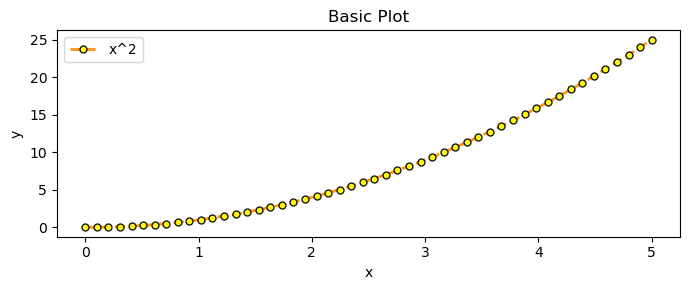

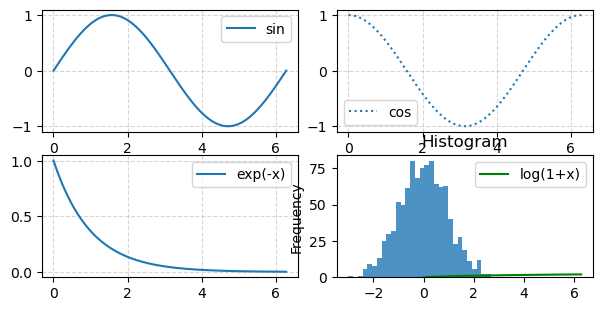

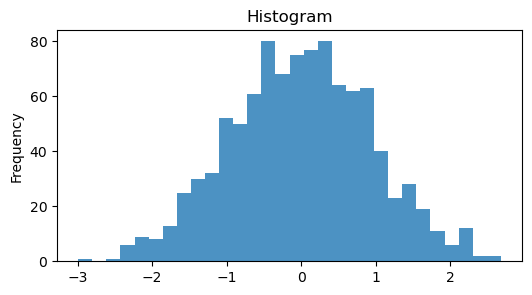

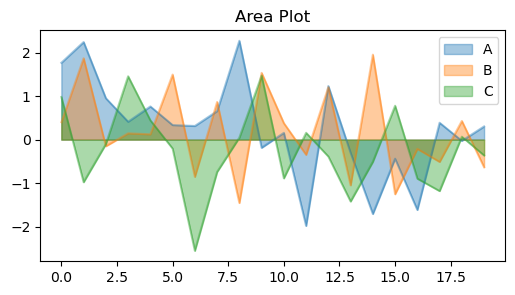

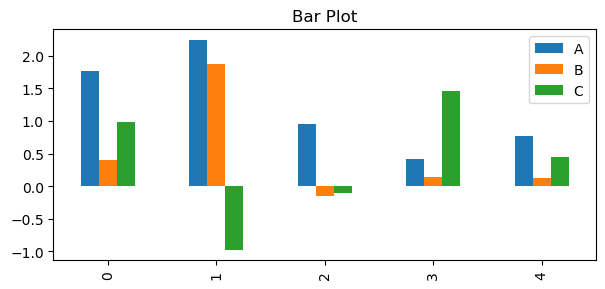

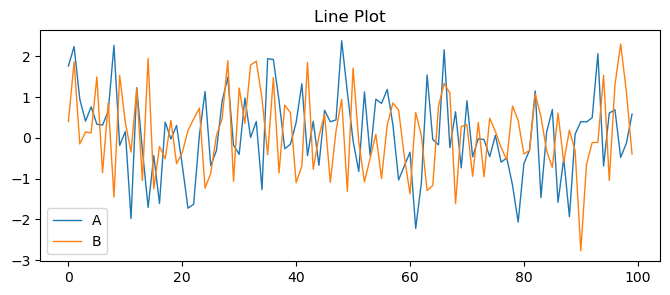

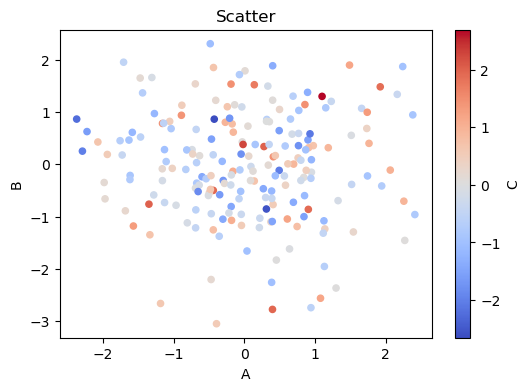

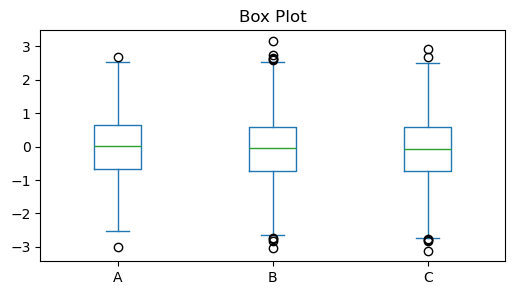

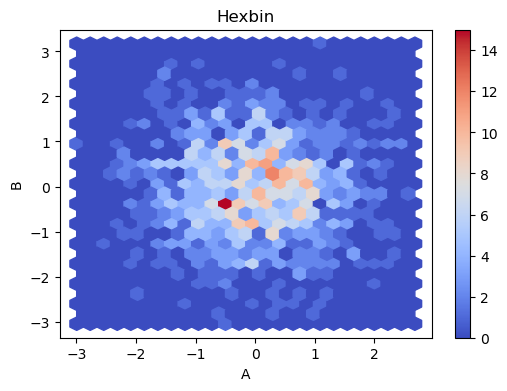

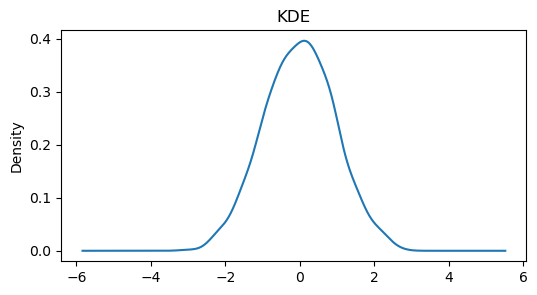

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(0)
df1 = pd.DataFrame(np.random.randn(1000, 3), columns=list("ABC"))

# Histogram
ax = df1['A'].plot.hist(bins=30, figsize=(6,3), alpha=0.8)
ax.set_title('Histogram')
plt.show()

# Area (fix: stacked=False to allow mixed-sign values)
ax = df1.iloc[:20].plot.area(alpha=0.4, figsize=(6,3), stacked=False)
ax.set_title('Area Plot')
plt.show()

# Bar
ax = df1.iloc[:5].plot.bar(figsize=(7,3))
ax.set_title('Bar Plot')
plt.show()

# Line
ax = df1[['A','B']].iloc[:100].plot(figsize=(8,3), lw=1)
ax.set_title('Line Plot')
plt.show()

# Scatter (color by C)
ax = df1.iloc[:200].plot.scatter(x='A', y='B', c='C', cmap='coolwarm', figsize=(6,4))
ax.set_title('Scatter')
plt.show()

# Box
ax = df1[['A','B','C']].plot.box(figsize=(6,3))
ax.set_title('Box Plot')
plt.show()

# Hexbin
ax = df1.plot.hexbin(x='A', y='B', gridsize=25, cmap='coolwarm', figsize=(6,4))
ax.set_title('Hexbin')
plt.show()

# KDE with fallback (requires SciPy in some setups)
try:
    ax = df1['A'].plot.kde(figsize=(6,3))
    ax.set_title('KDE')
    plt.show()
except Exception as e:
    print("KDE failed →", e)
    ax = df1['A'].plot.hist(bins=30, density=True, figsize=(6,3))
    ax.set_title('Hist (density fallback)')
    plt.show()


# Part 8 – Time Series Visualization (with Solutions)


In [11]:
import matplotlib.dates as mdates
idx = pd.date_range('2015-01-01', periods=1000, freq='D')
price = pd.Series(100 + np.cumsum(np.random.randn(len(idx))*0.5), index=idx)
df_ts = pd.DataFrame({'Adj Close': price, 'Adj Volume': np.random.randint(1e5, 3e5, len(idx))})

ax = df_ts['Adj Close'].plot(figsize=(10,3), lw=1, title='Adj Close')
ax.set_xlim(pd.Timestamp('2016-01-01'), pd.Timestamp('2017-01-01'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
ax.figure.autofmt_xdate()
ax.grid(ls='--', alpha=0.4)
plt.tight_layout()


# Part 9 – Time Series Plotting: Scales, Limits, and Date Formatters

Key ideas
- Plot **one series at a time** when y-scales differ (e.g., price vs. volume).
- Control **figure size** (`figsize=(12,4)`), **x/y limits** (`set_xlim`, `set_ylim`).
- Use `matplotlib.dates` **locators** (Month/Weekday) and **formatters** (`DateFormatter`) to customize tick labels.
- Fix overlapping date labels with `fig.autofmt_xdate()`.
- Add gridlines per-axis (`ax.xaxis.grid(True)`, `ax.yaxis.grid(True)`).
- Optional: Jupyter **interactive backend** (`%matplotlib notebook`) to pan/zoom (restart kernel first).


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

%matplotlib inline

# Synthetic McDonald's-like dataset for demo (replace with your CSV if you have it)
idx = pd.date_range('2006-01-01', '2010-01-01', freq='B')
rng = np.random.default_rng(0)
price = pd.Series(50 + rng.standard_normal(len(idx)).cumsum(), index=idx).abs() + 10
volume = pd.Series(rng.integers(1.5e6, 6e6, len(idx)), index=idx)
mcdon = pd.DataFrame({'Adj Close': price, 'Adj Volume': volume})

# 1) Plot each series separately if their scales are very different
fig, axes = plt.subplots(2, 1, figsize=(12,5), sharex=True)
mcdon['Adj Close'].plot(ax=axes[0], lw=1, title='Adjusted Close')
mcdon['Adj Volume'].plot(ax=axes[1], lw=1, title='Adjusted Volume')
for ax in axes: ax.grid(ls='--', alpha=0.4)
plt.tight_layout()

# 2) Focus on a time window with explicit x/y limits
ax = mcdon['Adj Close'].plot(figsize=(12,4), lw=1, title='Adj Close (2007–2009 focus)')
ax.set_xlim(pd.Timestamp('2007-01-01'), pd.Timestamp('2009-01-01'))
ax.set_ylim(20, 80)
ax.grid(ls='--', alpha=0.4)
plt.tight_layout()

# 3) Advanced date ticks: monthly major ticks, custom format
start = '2007-01-01'; end = '2007-05-01'
stock = mcdon.loc[start:end, 'Adj Close']

fig, ax = plt.subplots(figsize=(10,3))
ax.plot_date(stock.index, stock.values, '-', lw=1)
ax.xaxis.set_major_locator(mdates.MonthLocator())                      # locate by month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))            # e.g., Jan-2007
fig.autofmt_xdate()
ax.grid(ls='--', alpha=0.4)

# 4) Minor ticks example: add weekly minor ticks labeled by day-of-month
ax.xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=mdates.MO))  # all Mondays
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))                # day-of-month
for tick in ax.xaxis.get_minor_ticks():                                 # push minor labels lower
    tick.set_pad(15)
plt.tight_layout()


/var/folders/40/qq7n2_gd71l5n9hlkzt509b00000gn/T/ipykernel_9899/2883874258.py:34: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  ax.plot_date(stock.index, stock.values, '-', lw=1)


# Part 10 – Pandas Visualization Exercises (Solved)

We'll assume `df3.csv` exists (as in your course materials).  
Tasks covered:
1) Scatter: `B` vs `A`, with size and color tweaks
2) Histogram of `A` (+bins)
3) Apply a `matplotlib` style (e.g., `ggplot`)
4) Box plot of `A` and `B`
5) KDE (density) of `D` with custom line width and style
6) Area plot of first 30 rows
7) Bonus: Put the legend **outside** the plot


# 📊 Visualization Examples with Pandas & Matplotlib

This section demonstrates **different plot types** using a sample DataFrame (`df3`).  
We use Pandas' built-in `.plot()` methods, which are powered by Matplotlib.

---

## 🔵 1) Scatter Plot
Shows the relationship between two variables (`A` vs `B`).  
We customize:
- **Point size (`s`)**
- **Color (`c`)**
- Add **gridlines** for readability

Useful for **correlation analysis** and identifying clusters or outliers.

---

## 📊 2) Histogram
Displays the **distribution of values** for column `A`.  
We set:
- **Number of bins (`bins=30`)** to control granularity
- **Transparency (`alpha`)** for better overlap visualization

Helps detect skewness, modality (uni/multi-modal), and outliers.

---

## 🎨 3) Matplotlib Style
We apply the **`ggplot` style** to show how global styles affect plots.  
This is useful when you want consistent aesthetics across multiple figures.

---

## 📦 4) Box Plot
Summarizes the distribution of `A` and `B` with:
- Median (central line)
- Interquartile range (box)
- Whiskers and outliers

Great for comparing distributions side by side.

---

## 🌊 5) KDE (Kernel Density Estimation)
Plots a smooth curve of the **probability density function** of `D`.  
Dashed line and increased `lw` (line width) improve readability.

> ⚠️ If SciPy is not installed, we fall back to a histogram with `density=True`.

---

## 🟩 6) Area Plot
Visualizes stacked values over an index (like a cumulative view).  
Since our data may include positive & negative values, we set `stacked=False`  
to avoid Pandas' error about mixed-sign stacking.

---

## 🏷 7) Legend Outside
Demonstrates how to **move the legend outside the plot area** using:
```python
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


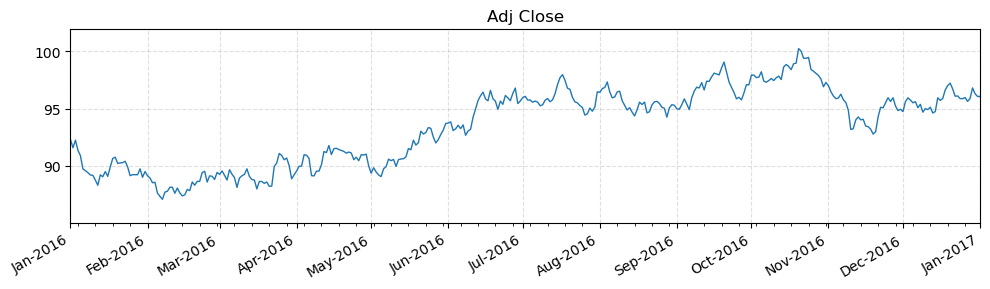

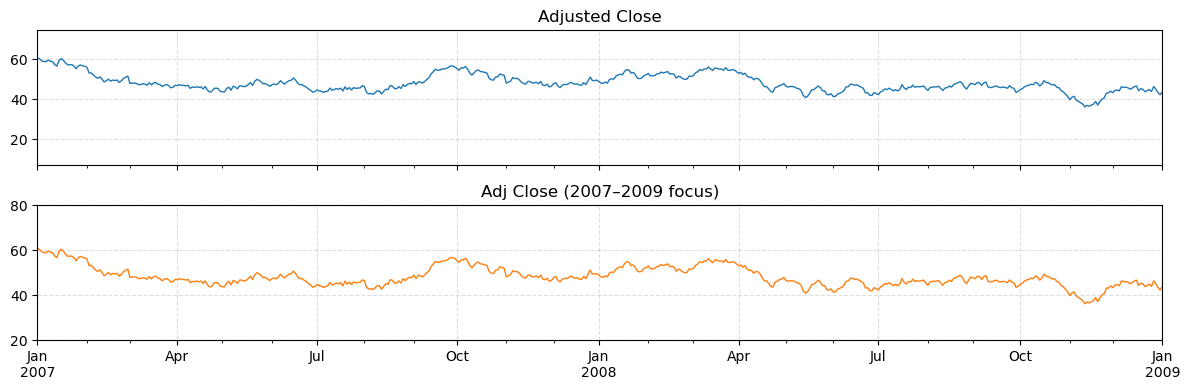

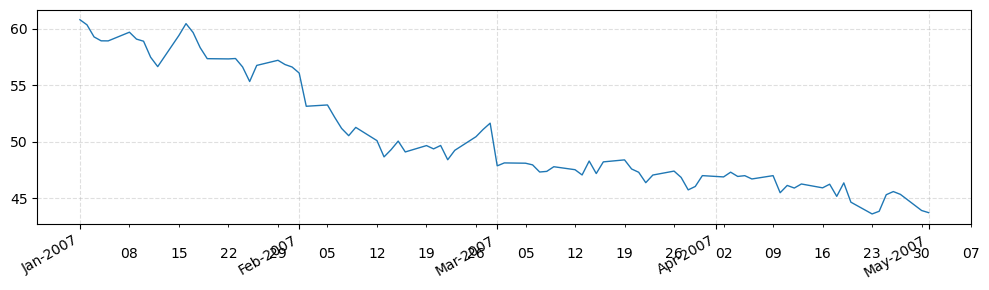

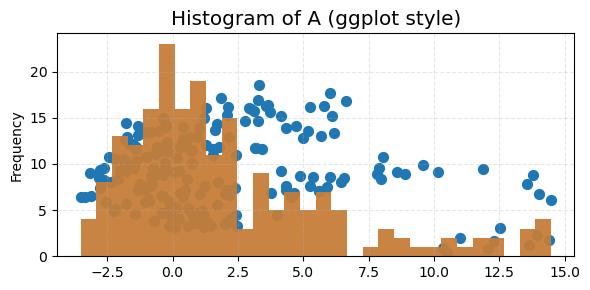

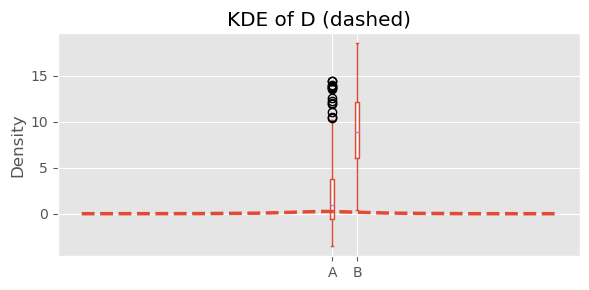

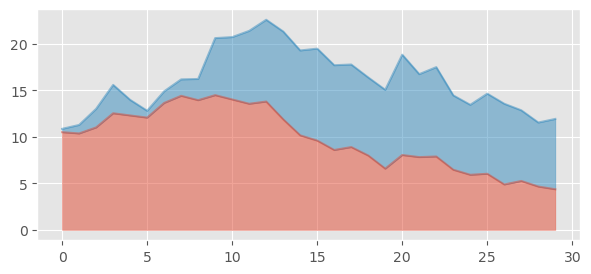

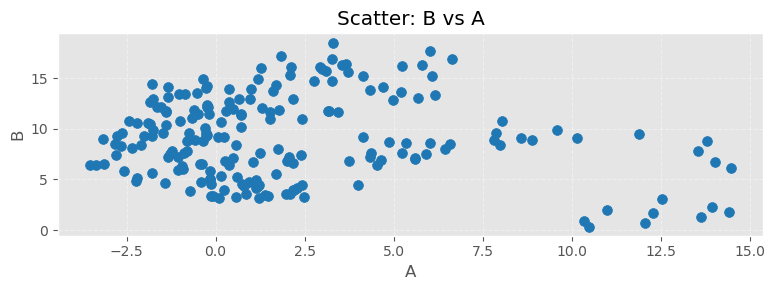

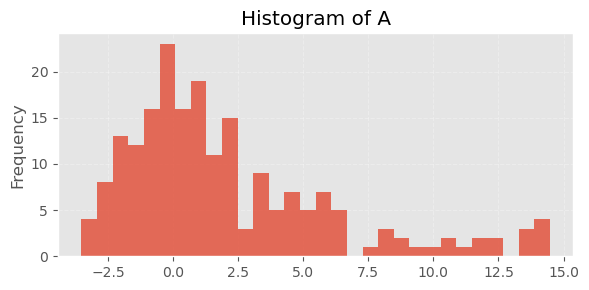

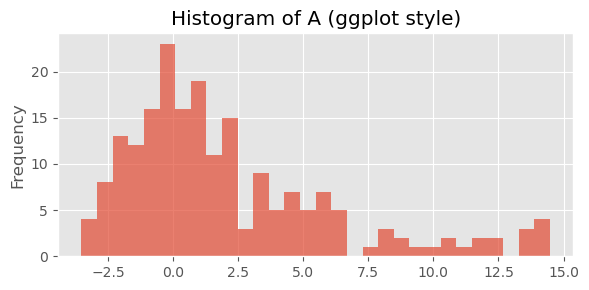

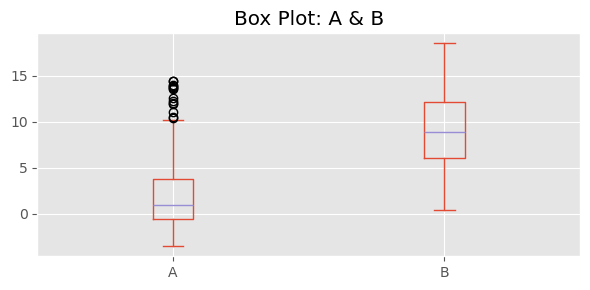

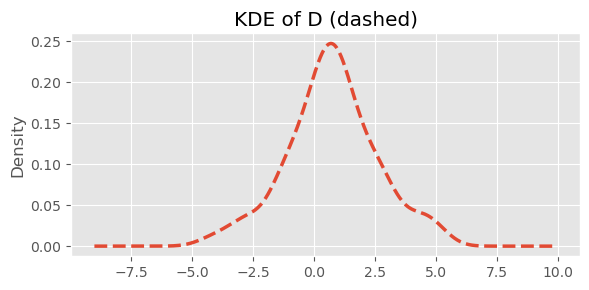

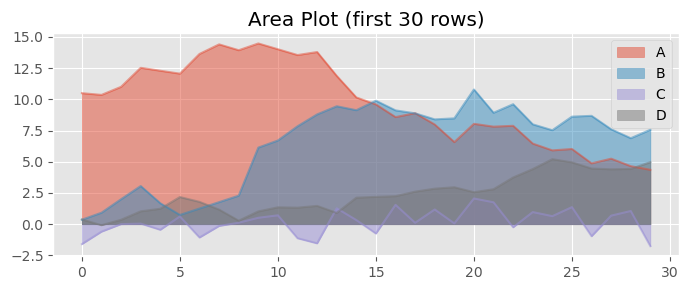

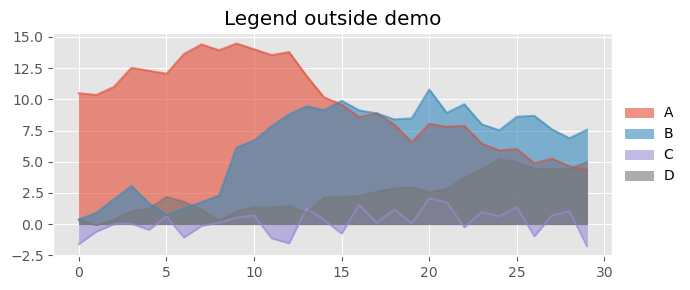

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# If you have df3.csv, load it. Otherwise, create a similar sample.
try:
    df3 = pd.read_csv('df3.csv')
except FileNotFoundError:
    np.random.seed(42)
    df3 = pd.DataFrame({
        'A': np.random.randn(200).cumsum() + 10,
        'B': np.random.randn(200).cumsum(),
        'C': np.random.randn(200),
        'D': np.random.randn(200).cumsum() * 0.5,
    })

# 1) Scatter A vs B (figsize + point size + color)
ax = df3.plot.scatter(x='A', y='B', figsize=(8,3), s=50, c='tab:blue', title='Scatter: B vs A')
ax.grid(ls='--', alpha=0.4)
plt.tight_layout(); plt.show()

# 2) Histogram of A with bins
ax = df3['A'].plot.hist(bins=30, figsize=(6,3), alpha=0.8, title='Histogram of A')
ax.grid(ls='--', alpha=0.3)
plt.tight_layout(); plt.show()

# 3) Use a style (ggplot), redo histogram of A
plt.style.use('ggplot')  # global style
ax = df3['A'].plot.hist(bins=30, figsize=(6,3), alpha=0.7, title='Histogram of A (ggplot style)')
plt.tight_layout(); plt.show()

# 4) Box plot (A vs B)
ax = df3[['A','B']].plot.box(figsize=(6,3), title='Box Plot: A & B')
plt.tight_layout(); plt.show()

# 5) KDE of D with lw & dashed line (fallback if SciPy missing)
try:
    ax = df3['D'].plot.kde(figsize=(6,3), lw=2.5, ls='--', title='KDE of D (dashed)')
    plt.tight_layout(); plt.show()
except Exception as e:
    print("KDE failed →", e)
    ax = df3['D'].plot.hist(bins=30, density=True, figsize=(6,3), alpha=0.7, title='Hist (density fallback for D)')
    plt.tight_layout(); plt.show()

# 6) Area plot of first 30 rows  (fix: stacked=False for mixed-sign data)
ax = df3.iloc[:30].plot.area(alpha=0.5, figsize=(7,3), title='Area Plot (first 30 rows)', stacked=False)
plt.tight_layout(); plt.show()

# 7) Bonus: Legend outside  (también stacked=False)
ax = df3.iloc[:30].plot.area(alpha=0.6, figsize=(7,3), title='Legend outside demo', stacked=False)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)
plt.tight_layout(); plt.show()


# Part 11 – Getting Market Data with `pandas_datareader`

Notes
- Historical APIs change often. The original Yahoo endpoint was removed; Google endpoint from old `pandas_datareader` is also not reliable now.
- Today, common options:
  - **Stooq** via `pandas_datareader` (no API key, daily bars).
  - **FRED** for macro series (no key for small volumes).
  - **Alpha Vantage / IEX Cloud / Polygon** (API keys required).
  - **`yfinance`** (third-party, popular for equities).

Below we show **Stooq** (robust for simple OHLCV) + a guarded example for Options (may be deprecated or region-blocked).

> If any call fails in your environment, use `yfinance` as fallback:
> ```python
> pip install yfinance
> import yfinance as yf
> yf.download("AAPL", start="2018-01-01", end="2019-01-01")
> ```


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pandas_datareader import data as web
from datetime import datetime

start = datetime(2018, 1, 1)
end   = datetime(2019, 1, 1)

# 1) Stooq example (usually reliable)
try:
    aapl = web.DataReader("AAPL", "stooq", start, end).sort_index()  # stooq returns desc by default
    display(aapl.head())
    ax = aapl['Close'].plot(figsize=(10,3), lw=1, title='AAPL Close (Stooq)')
    ax.grid(ls='--', alpha=0.4)
    plt.tight_layout()
except Exception as e:
    print("Stooq fetch failed:", e)

# 2) FRED macro example (no key for small volumes)
try:
    # Industrial Production Index
    ip = web.DataReader("INDPRO", "fred", start, end)
    ax = ip.plot(figsize=(8,3), lw=1.5, title='FRED: Industrial Production (INDPRO)')
    ax.grid(ls='--', alpha=0.4)
    plt.tight_layout()
except Exception as e:
    print("FRED fetch failed:", e)

# 3) (Experimental) Options – this API may be deprecated; guarded with try/except
try:
    from pandas_datareader.data import Options
    opt = Options('AAPL', 'yahoo')  # source may fail
    expiries = opt.expiry_dates
    if expiries:
        calls = opt.get_call_data(expiry=expiries[0])
        display(calls.head())
    else:
        print("No expiry dates returned.")
except Exception as e:
    print("Options fetch failed or endpoint unsupported:", e)


,Open,High,Low,Close,Volume
Date,,,,,
2018-01-02,39.9866,40.4883,39.7750,40.4794,108596378
2018-01-03,40.5435,41.0145,40.4064,40.4725,125393932
2018-01-04,40.5454,40.7661,40.4361,40.6639,95104622
2018-01-05,40.7582,41.2136,40.6699,41.1220,100413538
2018-01-08,40.9712,41.2677,40.8748,40.9811,87365935


Options fetch failed or endpoint unsupported: 
Yahoo Options has been immediately deprecated due to large breaks in the API without the
introduction of a stable replacement. Pull Requests to re-enable these data
connectors are welcome.

See https://github.com/pydata/pandas-datareader/issues



# Part 12 – Quandl (a.k.a. Nasdaq Data Link) – Free API Usage

Notes
- The Python package is `quandl` (older name; service is now **Nasdaq Data Link**).
- Without an API key, daily call limits apply (e.g., ~50/day).  
  Set key via:
  ```python
  import quandl
  quandl.ApiConfig.api_key = "YOUR_KEY"


In [17]:

## 💻 CODE CELL
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

try:
    import quandl
except ImportError:
    !pip -q install quandl
    import quandl

# Optional: set your API key to avoid strict limits
# quandl.ApiConfig.api_key = "YOUR_API_KEY"

# 1) Single series: EIA WTI Crude Oil (code may still be available; if not, try other EIA series)
try:
    oil = quandl.get("EIA/PET_RWTC_D")  # WTI Cushing, Daily
    display(oil.tail())
    ax = oil.plot(figsize=(10,3), lw=1.2, title='WTI Crude Oil (EIA)')
    ax.grid(ls='--', alpha=0.4)
    plt.tight_layout()
except Exception as e:
    print("Could not fetch EIA series via Quandl:", e)

# 2) Zillow example (codes evolve; this may 404 depending on availability)
try:
    # Example: Zillow Rental Index per square foot, San Francisco (legacy code)
    zillow = quandl.get("ZILLOW/C9_ZRISFRR")
    display(zillow.tail())
    ax = zillow.plot(figsize=(8,3), lw=1.2, title='Zillow Index – Example')
    ax.grid(ls='--', alpha=0.4)
    plt.tight_layout()
except Exception as e:
    print("Zillow example may be deprecated or moved:", e)

# 3) Table-style queries (if a free table is available)
# Example template (will fail if dataset is not free/available):
# try:
#     prices = quandl.get_table('WIKI/PRICES', ticker='AAPL', date={'gte':'2017-01-01','lte':'2017-12-31'})
#     display(prices.head())
# except Exception as e:
#     print("Table access example unavailable:", e)


Could not fetch EIA series via Quandl: (Status 403) Something went wrong. Please try again. If you continue to have problems, please contact us at connect@quandl.com.
Zillow example may be deprecated or moved: (Status 403) Something went wrong. Please try again. If you continue to have problems, please contact us at connect@quandl.com.
